In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from os.path import join
import sys
sys.path.append("../")
sys.path.append("../model")

## 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns

## encoding 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

## vocabulary
import tensorflow_datasets as tfds

## tokenizer 
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

## preprocessor
from custom_preprocessor import Preprocessor

## model
from transformer_v1 import transformer
from transformers import TFBertForSequenceClassification, BertConfig
from tensorflow.keras import backend as K

# Data 준비

In [10]:
preprocessor = Preprocessor()
preprocessed_train, preprocessed_test = preprocessor.preprocess()

In [11]:
preprocessed_train["conversation"].apply(lambda x: len(x.split())).max()

## CLASS_NAMES에 '일반 대화'를 포함시킴
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 수동 매핑 설정
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}


# 'class' 열을 수동 매핑 적용하기 전에 문자열로 변환
preprocessed_train['class'] = preprocessed_train['class'].astype(str).map(class_mapping)
labels = preprocessed_train['class']

In [12]:
conversations_list = []
for conv in preprocessed_train['conversation']:
    conversations_list.append(conv)    

In [13]:
test_size_rate = 0.2
val_size_rate = 0.1

# 시드값 설정
seed = 1004
X_train, X_test, y_train, y_test = train_test_split(
    conversations_list, 
    labels, 
    test_size=test_size_rate, 
    stratify=labels, 
    random_state=seed
)


X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=val_size_rate, 
    stratify=y_train, 
    random_state=seed
)

In [14]:
print(len(X_train), y_train.shape)
print(len(X_valid), y_valid.shape)
print(len(X_test), y_test.shape)

3582 (3582,)
398 (398,)
996 (996,)


## 토큰화 및 모델 정의

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

token_X_train = tokenizer(
    X_train, 
    truncation=True, 
    padding=True, 
    max_length=191, 
) 

token_X_valid = tokenizer(
    X_valid, 
    truncation=True, 
    padding=True, 
    max_length=191, 
) 

token_X_test = tokenizer(
    X_test, 
    truncation=True, 
    padding=True, 
    max_length=191, 
)

In [16]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

# 클래스 가중치 계산 (클래스 4 포함)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 각 샘플에 가중치 할당
sample_weights = np.array([class_weights[y] for y in y_train])

# from_tensor_slices에서 입력을 딕셔너리로 전달
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(token_X_train),
    y_train
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(token_X_valid),
    y_valid
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(token_X_test),
    y_test
))

# 데이터셋을 섞고, 배치 처리
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Load the pretrained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

# Freeze all layers except the classification layer
for layer in model.layers:
    if 'bert' in layer.name:
        layer.trainable = False

# Ensure dropout is disabled
for layer in model.layers:
    if 'dropout' in layer.name:
        layer.rate = 0.0  # Disable dropout


Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

404 Client Error: Not Found for url: https://huggingface.co/klue/bert-base/resolve/main/tf_model.h5


OSError: Can't load weights for 'klue/bert-base'. Make sure that:

- 'klue/bert-base' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'klue/bert-base' is the correct path to a directory containing a file named one of tf_model.h5, pytorch_model.bin.



In [ ]:
#지희 수정
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels=5
)

for layer in model.layers:
    if 'bert' in layer.name:
        layer.trainable = False
    elif 'dropout' in layer.name:
        layer.trainable = False  
        
model.summary()

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)

In [ ]:
# def loss_function(y_true, y_pred):
#     y_true = tf.squeeze(y_true, axis=-1)
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(
#         from_logits=False)(y_true, y_pred)
#     return tf.reduce_mean(loss)

def recall_m(y_true, y_pred):

    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5),K.floatx())
    true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    recall_ratio = true_positives / (possible_positives + K.epsilon())
    return recall_ratio

def precision_m(y_true, y_pred):

    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5), K.floatx())
    true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(y_pred)
    precision_ratio = true_positives / (predicted_positives + K.epsilon())
    return precision_ratio

def f1_m(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

#     def __init__(self, d_model, warmup_steps=4000):
#         super(CustomSchedule, self).__init__()

#         self.d_model = d_model
#         self.d_model = tf.cast(self.d_model, tf.float32)

#         self.warmup_steps = warmup_steps

#     def __call__(self, step):
#         arg1 = tf.math.rsqrt(step)
#         arg2 = step * (self.warmup_steps**-1.5)

#         return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [20]:
EPOCHS = 500
BATCH_SIZE = 16
lr = 1e-5

In [21]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr, 
#     beta_1=0.9, 
#     beta_2=0.98, 
#     epsilon=1e-9
)

model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[f1_m]
)

# 학습

In [22]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = "val_loss", 
    patience = 2, 
    mode = "min"
)

In [23]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,  # 검증 데이터셋 추가
    epochs=EPOCHS,
    verbose=1, 
#     batch_size = BATCH_SIZE,
#     class_weight=class_weights,  # class_weight 사용
    callbacks = [early_stopping]
)

Epoch 1/500
224/224 [==============================] - 66s 251ms/step - loss: 1.6120 - f1_m: 0.0000e+00 - val_loss: 1.6067 - val_f1_m: 0.0000e+00
Epoch 2/500
224/224 [==============================] - 54s 242ms/step - loss: 1.6061 - f1_m: 0.0000e+00 - val_loss: 1.6000 - val_f1_m: 0.0000e+00
Epoch 3/500
224/224 [==============================] - 55s 245ms/step - loss: 1.5993 - f1_m: 0.0000e+00 - val_loss: 1.5936 - val_f1_m: 0.0000e+00
Epoch 4/500
224/224 [==============================] - 56s 249ms/step - loss: 1.5881 - f1_m: 0.0000e+00 - val_loss: 1.5821 - val_f1_m: 0.0000e+00
Epoch 6/500
224/224 [==============================] - 56s 250ms/step - loss: 1.5856 - f1_m: 0.0000e+00 - val_loss: 1.5766 - val_f1_m: 0.0000e+00
Epoch 7/500
224/224 [==============================] - 56s 251ms/step - loss: 1.5804 - f1_m: 0.0000e+00 - val_loss: 1.5712 - val_f1_m: 0.0000e+00
Epoch 8/500
224/224 [==============================] - 56s 252ms/step - loss: 1.5743 - f1_m: 0.0000e+00 - val_loss: 1.5659 -

NameError: name 'acc_ax' is not defined

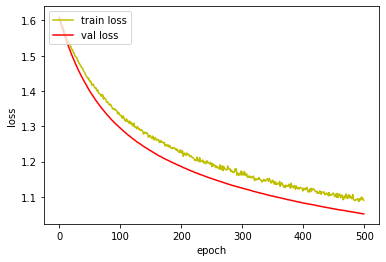

In [24]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

# acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [25]:
## 모델 평가
evaluation = model.evaluate(test_dataset)

63/63 [==============================] - 13s 205ms/step - loss: 1.0325 - f1_m: 0.7353


In [26]:
# sweep_id = wandb.sweep(sweep_config,
#                        entity = <<YOUR CODE>>,
#                        project = <<YOUR CODE>>)

# # run the sweep
# wandb.agent(sweep_id,
#             function=train,
#             count=10)

# submission

In [27]:
conversations_test_list = []
for conv in preprocessed_test['text']:
    conversations_test_list.append(conv)

token_test = tokenizer(
    conversations_test_list, 
    truncation=True, 
    padding=True, 
    max_length=191, 
) 

pred = model.predict(token_test["input_ids"])

pred_prob = tf.nn.softmax(pred.logits, axis=-1).numpy()
pred_class = np.argmax(pred_prob, axis=1)

In [28]:
pred_class

array([2, 4, 4, 4, 2, 4, 2, 4, 4, 1, 0, 3, 2, 4, 2, 2, 3, 2, 4, 3, 4, 4,
       4, 4, 1, 4, 4, 4, 2, 4, 4, 2, 4, 1, 2, 4, 4, 4, 4, 4, 3, 4, 2, 1,
       4, 2, 4, 4, 4, 3, 4, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 1, 4, 4, 4, 2,
       4, 2, 4, 4, 2, 0, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 2, 4, 0, 4, 4,
       4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 2, 4, 4, 2, 4,
       1, 4, 4, 2, 4, 4, 2, 4, 2, 1, 4, 4, 4, 4, 2, 4, 2, 4, 1, 4, 2, 4,
       4, 4, 1, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 0, 4, 0, 0, 4, 2, 2, 4, 2,
       4, 4, 4, 2, 2, 4, 4, 2, 4, 4, 3, 4, 4, 3, 4, 2, 3, 2, 2, 2, 2, 4,
       2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 2, 4, 4, 0, 4, 4, 4, 4, 0, 4, 0, 2, 4, 4, 2, 0, 4, 4, 1, 4, 4,
       1, 4, 4, 4, 2, 1, 2, 4, 4, 1, 2, 4, 2, 2, 2, 1, 3, 4, 4, 4, 2, 4,
       4, 2, 2, 4, 4, 4, 2, 0, 4, 2, 4, 4, 4, 3, 4, 2, 4, 4, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 2, 0, 4, 4, 2, 2, 2, 2, 2, 2, 4, 1, 2, 4, 4, 4, 4,
       4, 2, 4, 4, 3, 2, 2, 4, 2, 2, 4, 4, 4, 0, 4,

In [29]:
def save_submission(y_pred, user_name, f1_score=None):
    data_path ="../data"
    save_path ="../submission"
    submission_path = join(data_path, 'new_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['class'] = y_pred
    submission_csv_path = '{}/submission_{}_f1score_{}.csv'.format(save_path, user_name, f1_score)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [30]:
save_submission(pred_class,'YJH_tfbert_full',0.73)

../submission/submission_YJH_tfbert_full_f1score_0.73.csv saved!
